# Classifier for Breast Cancer

- Different Classification Models
- Evaluation (Durations, Performance, Visualization)
- Feature Importance
- SHAP Values
- Cost Matrix / Optimal Threshold

Dataset: Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image in the 3-dimensional space

Author: Enrico Lauckner ([github.com/elauckne](github.com/elauckne))

In [1]:
import pandas as pd
import numpy as np

from eli5.sklearn import PermutationImportance
from eli5 import show_weights

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, log_loss, accuracy_score, confusion_matrix
from src.plots_classification import *
from src.model import create_cv_model, shap_summary, plot_feature_importance

## Load Data

In [2]:
from sklearn import datasets

In [3]:
bc = datasets.load_breast_cancer()

In [4]:
bc.target_names

array(['malignant', 'benign'], dtype='<U9')

In [5]:
bc.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [6]:
class_0, class_1 = bc.target_names[0], bc.target_names[1]
feat_cols = bc.feature_names
ids = np.arange(bc.data.shape[0])+1
y = bc.target
x = bc.data

In [7]:
print(ids.shape)
print(y.shape)
print(x.shape)

(569,)
(569,)
(569, 30)


### Cost Matrix

Arbitrary Cost Matrix:
* Correctly identified benign: 5
* Correctly identified malignant: 10
* Predicted benign, actually malignant: -10
* Predicted malignant, actually benign: -5

In [8]:
cost_mat = np.array([[5, -10], [-5, 1]], np.int64)
cost_mat

array([[  5, -10],
       [ -5,   1]], dtype=int64)

### CV Fold

In [9]:
cv_fold = StratifiedKFold(n_splits = 10, random_state = 123)

### Scale

In [10]:
qt = QuantileTransformer(output_distribution = 'uniform')
qt.fit(x)
x_qt = qt.transform(x)
x_qt.shape

(569, 30)

## Model

#### Logistic Regression

In [11]:
lr = LogisticRegression()
lr_model = create_cv_model(lr, x_qt, y, ids, cv_fold, cost_mat)

#### Naive Bayes

In [13]:
bnb = BernoulliNB(binarize = None)
bnb_model = create_cv_model(bnb, x_qt, y, ids, cv_fold, cost_mat)

#### K-Nearest-Neighbors

In [15]:
knn = KNeighborsClassifier(n_neighbors = 20)
knn_model = create_cv_model(knn, x_qt, y, ids, cv_fold, cost_mat)

#### Random Forest

In [17]:
rf = RandomForestClassifier(n_estimators = 100, n_jobs = 4)
rf_model = create_cv_model(rf, x_qt, y, ids, cv_fold, cost_mat)

#### Stochastic Gradient Descent

SGDClassifier(loss = 'perceptron') equal to Perceptron

In [19]:
sgd = SGDClassifier(loss = 'log', penalty = 'elasticnet', learning_rate = 'optimal', max_iter = 1000, tol = 0.0001)
sgd_model = create_cv_model(sgd, x_qt, y, ids, cv_fold, cost_mat)

#### Gradient Boosting

In [21]:
gb = GradientBoostingClassifier()
gb_model = create_cv_model(gb, x_qt, y, ids, cv_fold, cost_mat)

#### Support Vector Machine

In [23]:
svc = SVC(kernel = 'rbf', probability = True)
svc_model = create_cv_model(svc, x_qt, y, ids, cv_fold, cost_mat)

## Evaluate all models

In [25]:
models = []

models.append(('LogReg', lr_model))
models.append(('Bayes', bnb_model))
models.append(('KNN', knn_model))
models.append(('RF', rf_model))
models.append(('SGD', sgd_model))
models.append(('G.Boost', gb_model))
models.append(('SVM', svc_model))

In [26]:
names = []
durations = []
results_roc = []
results_acc = []
results_ll = []
results_pl = []

for name, model in models:
    names.append(name)
    durations.append(model['duration'])
    results_roc.append(model['auroc'])
    results_acc.append(model['accuracy'])
    results_ll.append([x * -1 for x in model['logloss']])
    results_pl.append(model['profit_loss'])

In [27]:
md_roc = [round(np.median(x),3) for x in results_roc]
md_acc = [round(np.median(x),3) for x in results_acc]
md_ll = [round(np.median(x),3) for x in results_ll]
md_pl = [round(np.median(x)) for x in results_pl]

result_df = pd.DataFrame([md_roc, md_acc, md_ll, md_pl], columns = names, 
                         index = ['AUROC', 'Accuracy', 'NLogLoss', 'Profit_Loss']).T

In [28]:
result_df

,AUROC,Accuracy,NLogLoss,Profit_Loss
LogReg,0.997,0.965,-0.142,123.0
Bayes,0.991,0.948,-0.128,111.0
KNN,0.997,0.974,-0.095,126.0
RF,0.997,0.965,-0.099,122.0
SGD,0.996,0.965,-0.243,120.0
G.Boost,0.997,0.965,-0.091,120.0
SVM,0.998,0.974,-0.065,128.0


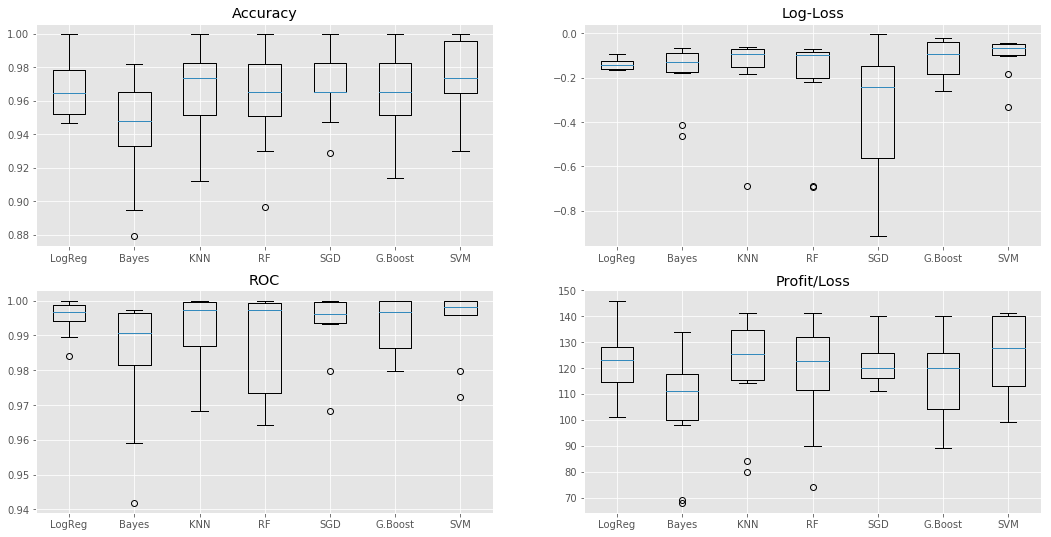

In [29]:
plt.figure(figsize=(18,9))

plt.subplot(2,2,1)
plt.title('Accuracy')
plt.boxplot(results_acc, labels = names)

plt.subplot(2,2,2)
plt.title('Log-Loss')
plt.boxplot(results_ll, labels = names)

plt.subplot(2,2,3)
plt.title('ROC')
plt.boxplot(results_roc, labels = names)

plt.subplot(2,2,4)
plt.title('Profit/Loss')
plt.boxplot(results_pl, labels = names)

plt.show()

## Duration

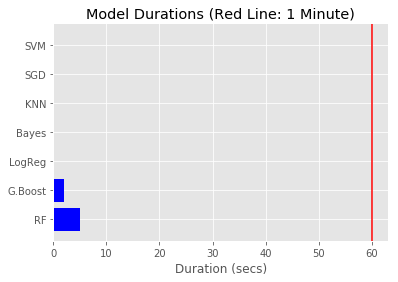

In [30]:
duration_df = pd.DataFrame([names, durations], index=['model', 'duration']).T.sort_values('duration', ascending = False)

plt.barh(range(duration_df.shape[0]), duration_df['duration'], color = 'b', align = 'center')
plt.yticks(range(duration_df.shape[0]), duration_df['model'].values)
plt.xlabel('Duration (secs)')
plt.axvline(x = 60, color = 'r', linestyle = '-')
plt.title('Model Durations (Red Line: 1 Minute)')
plt.show()

## Best Model

Winner of most categories, in a tie 'Profit/Loss' decides

In [31]:
best_df = pd.DataFrame([result_df.idxmax(), result_df.idxmin()], index = ['Max', 'Min']).T
best_df

,Max,Min
AUROC,SVM,Bayes
Accuracy,KNN,Bayes
NLogLoss,SVM,SGD
Profit_Loss,SVM,Bayes


In [32]:
best_candidates = best_df['Max'].mode().values
if len(best_candidates) > 1: best = best_df['Max'].loc['Profit_Loss']
else: best = best_candidates

for name, model in models:
    if name == best: best_model = model; print(name)

SVM


In [33]:
from pickle import dump

with open('data/best_model.pkl', 'wb') as f:
    dump(best_model, f)

### Evaluation Plot

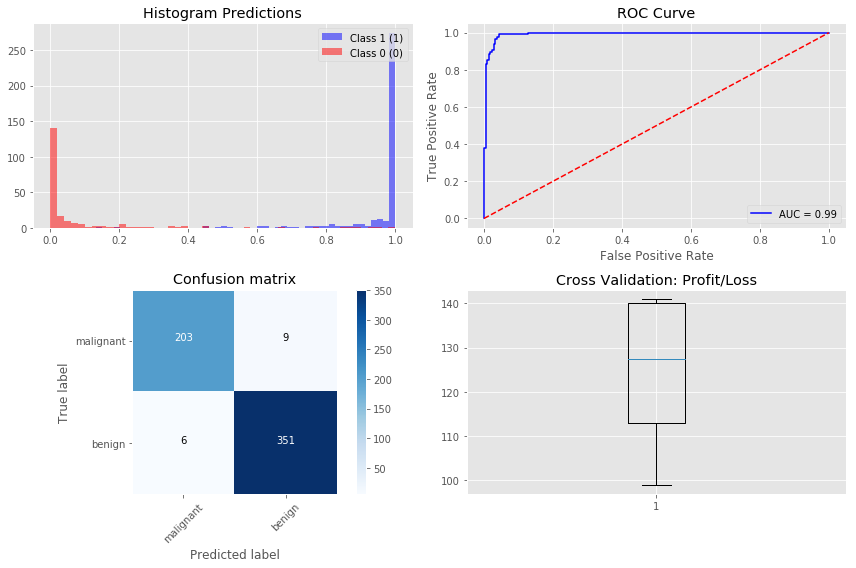

In [43]:
classification_plot(best_model['test_df'].truth, best_model['test_df'].proba, 
                    best_model['profit_loss'], class_0, class_1)

### Feature Importance

Fit best model again on whole data

In [34]:
best_fit = best_model['model'].fit(x,y)
best_fit_rf = rf_model['model'].fit(x,y)

#### Permutation Importance

In [35]:
perm = PermutationImportance(best_fit, random_state=1).fit(x, y)
show_weights(perm, feature_names = feat_cols)

Weight,Feature
0.3694 ± 0.0014,mean area
0.3680 ± 0.0036,worst area
0.3511 ± 0.0093,worst perimeter
0.3371 ± 0.0121,mean perimeter
0.3332 ± 0.0209,area error
0.2134 ± 0.0065,worst texture
0.2070 ± 0.0093,worst radius
0.1441 ± 0.0200,mean texture
0.1385 ± 0.0159,mean radius
0.0383 ± 0.0060,perimeter error


#### SHAP Values

In [36]:
%%time
%%capture
plot_shap_summary = shap_summary(best_fit, x, feat_cols)

Wall time: 21min 32s


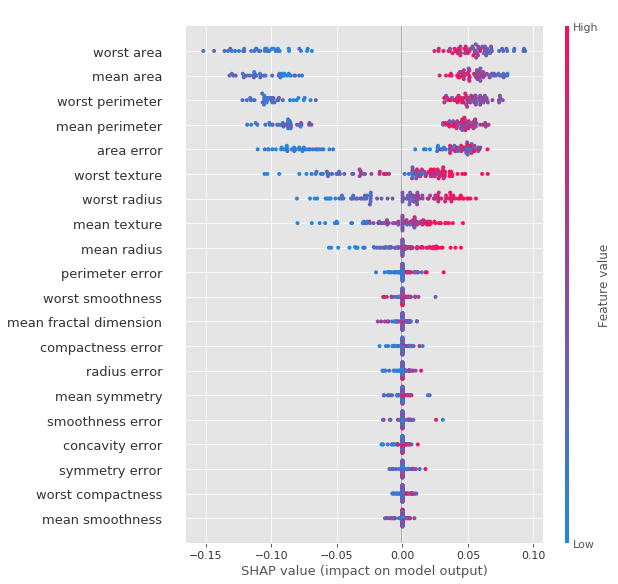

In [37]:
plot_shap_summary

### Optimal Threshold

In [44]:
test_df = svc_model['test_df']
results = []

for threshold in range(5,100, 5):
    threshold = threshold / 100

    y = test_df['truth'].values
    y_hat = np.where(test_df['proba'].values >= threshold, 1, 0)
    rating = np.sum(confusion_matrix(y, y_hat) * cost_mat)

    results.append([threshold, rating])
    
pd.DataFrame(results, columns=['Threshold', 'Rating']).sort_values('Rating', ascending = False).head()

,Threshold,Rating
8,0.45,1255
9,0.50,1252
11,0.60,1249
7,0.40,1240
10,0.55,1234
